In [2]:
%matplotlib inline

In [33]:
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# notebook specific imports
import pickle
import gsheets_importer
import math
from scipy import stats
import time
import random
import warnings

In [5]:
packerstation_path = '/home/jamesrowland/Documents/packerstation/jrowland/Data'
pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/RL048/run24.pkl'

with open(pkl_path, 'rb') as f:
    run = pickle.load(f)

In [46]:
figure_path = '/home/jamesrowland/Documents/Code/Vape/figures/s1s2_imaging_subsets_prototype'

In [6]:
#s2p_path = packerstation_path + run.s2p_path.split('Data')[1]
s2p_path = '/home/jamesrowland/Documents/packerstation/jrowland/Data/2019-08-03/2019-08-03_RL048_t-004/suite2p'

In [58]:
plane1_path = os.path.join(s2p_path, 'plane0')

flu, spks, stat = utils.s2p_loader(plane1_path)
flu = utils.dfof2(flu)
n_cells = flu.shape[0]
fs = 5 # imaging samping rate (read this from suite2p in the future)
flu.shape

Loading 1387 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7


(1387, 17958)

In [59]:
from numpy import unravel_index
idx = unravel_index(flu.argmax(), flu.shape)
stat[idx[0]]['original_index']

2458

In [60]:
np.max(spks)

1855.293

In [8]:
# the lengths of the actual tseries
tseries_lens = run.num_frames
# get the frame ttls recorded in paqio that actually correspond to analysed tseries
paqio_frames = utils.tseries_finder(tseries_lens, run.frame_clock)
len(paqio_frames)

42501

In [9]:
# the final one was not fully paqqed
flu.shape[1] * 3 - tseries_lens[-1]

42500

In [10]:
sum(tseries_lens[0:-1])

42501

In [11]:
# convert paqio recorded frames to pycontrol ms
frames_ms = run.prereward_aligner.B_to_A(paqio_frames)

In [12]:
lick_start_frames = utils.stim_start_frame(frame_clock=frames_ms,stim_times=run.pre_licks)
lick_idx = [i for i, f in enumerate(frames_ms) if f in lick_start_frames]

lick_frame_bool = np.repeat(False, len(frames_ms))
lick_frame_bool[lick_idx] = True

In [13]:
preframes_idx = np.argwhere(~np.isnan(frames_ms))
preflu = np.squeeze(flu[:,preframes_idx])
preflu = preflu[:, 1::3] # for plane 1

preframes_ms = np.squeeze(frames_ms[preframes_idx])
preframes_ms = preframes_ms[1::3] # for plane 1

licks = run.pre_licks

preflu.shape

(1536, 430)

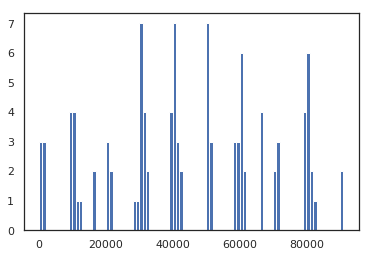

In [14]:
bin_size_ms = 1000
plt.figure()
lick_hist = plt.hist(licks, bins=range(0,max(licks)+bin_size_ms,bin_size_ms))

In [15]:
onset_bin_ms = utils.threshold_detect(lick_hist[0], 0.5) * bin_size_ms
onset_bin_ms

array([    0,  9000, 16000, 20000, 28000, 39000, 50000, 58000, 66000,
       70000, 79000, 90000])

In [16]:
first_lick_bin = [min(licks, key=lambda x:abs(x-ms)) for ms in onset_bin_ms]
frame_lick_idx = [utils.closest_frame_before(preframes_ms, lick) for lick in first_lick_bin]

In [17]:
%%capture

mean_flu = np.mean(preflu, 0)

n_frames_plot = 5

x_axis = np.linspace(-n_frames_plot, n_frames_plot, 2*n_frames_plot)

plt.figure(figsize=(16,16))           
             
for i, idx in enumerate(frame_lick_idx):
    
    plt.subplot(5, int(np.ceil(len(frame_lick_idx)/5)), i+1)
    
    if idx <= n_frames_plot or idx + n_frames_plot > len(mean_flu):
        continue
        
    pre = mean_flu[idx-n_frames_plot:idx]
    post = mean_flu[idx:idx+n_frames_plot]
    
    utils.raster_plot((licks - preframes_ms[idx]) / 1000, y_pos=0, marker='.', color='red')
    
    plt.plot(x_axis, np.hstack((pre, post)))
    plt.ylim((-0.1,0.7))
    plt.xlim((min(x_axis), max(x_axis)))
    

In [41]:
# meaned bulk trial fluoresence
lick_flu = []
spont_flu = []

trial_len = 5

mean_flu_all = np.mean(flu,0)

final_pre_frame = max(np.ravel(preframes_idx))

for idx in frame_lick_idx:
    
    if idx+trial_len >= len(mean_flu): continue
    
    [lick_flu.append(f) for f in mean_flu[idx:idx+trial_len]]
    
    tstart_spont = idx+final_pre_frame
    [spont_flu.append(f) for f in mean_flu_all[tstart_spont:tstart_spont+trial_len]]

print(np.mean(lick_flu))
print(np.mean(spont_flu))


np.save('/home/jamesrowland/Documents/Code/Vape/lick_flu.npy', lick_flu)
np.save('/home/jamesrowland/Documents/Code/Vape/spont_flu.npy', spont_flu)



-0.022085693
-0.06858599


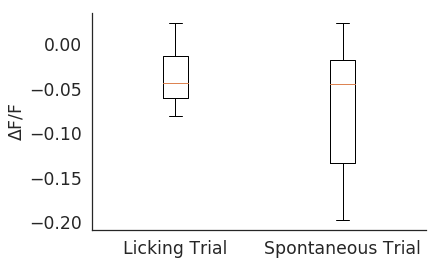

In [47]:
b = plt.boxplot([lick_flu, spont_flu], positions=[1,2], 
                labels=['Licking Trial', 'Spontaneous Trial'],
                showfliers=False)

l = plt.ylabel(r'$\Delta $F/F')
plt.savefig(os.path.join(figure_path, 'lick_boxes.png'), bbox_inches='tight')

In [24]:
# all flu vales

lick_flu = []
spont_flu = []

for idx in frame_lick_idx:
    
    if idx+trial_len >= len(mean_flu): continue
        
    [lick_flu.append(f) for f in mean_flu[idx:idx+trial_len]]
        
    
    
    print(idx)    


0
46
81
100
144
197
251
294
333
351
396


In [99]:
np.mean(lick_flu)

-0.021239974

In [80]:
idx = np.ravel(frame_lick_idx)[1]


idx+ max(np.ravel(preframes_idx))

9264

In [88]:
max(preframes_idx)

array([9218])

In [76]:
idx+trial_len+max(preframes_idx)

array([9274])

In [79]:
def test_responsive(flu, frame_clock, stim_times, pre_frames = 10, post_frames = 10, offset=0):

    n_frames = flu.shape[1]

    pre_idx = np.repeat(False, n_frames)
    post_idx = np.repeat(False, n_frames)
    # keep track of the previous stim frame to warn against overlap
    prev_frame = 0
                      
    for i, stim_time in enumerate(stim_times):

        stim_frame = utils.closest_frame_before(frame_clock, stim_time) 

        if stim_frame-pre_frames <= 0 or stim_frame+post_frames+offset >= n_frames:
            continue
        elif stim_frame - pre_frames <= prev_frame:
            print('WARNING: STA for stim number {} '
                  'overlaps with the previous stim '
                  'pre and post arrays can not be '
                  'reshaped to trial by trial'
                  .format(i))
                   
        prev_frame = stim_frame
              
        pre_idx[stim_frame-pre_frames : stim_frame] = True
        post_idx[stim_frame+offset : stim_frame+post_frames+offset] = True
        

    pre = flu[:, pre_idx]
    post = flu[:, post_idx]

    _, pvals = stats.ttest_ind(pre, post, axis=1)

    return pre, post, pvals

In [80]:
pre_frames = 5
post_frames = 5

pre, post, pvals = test_responsive(preflu, preframes_ms, first_lick_bin, pre_frames, post_frames, offset=5)

print(np.mean(post.ravel()) - np.mean(pre.ravel()))


pre = np.reshape(pre, (pre.shape[0], pre_frames, int(pre.shape[1]/pre_frames)))
post = np.reshape(post, (post.shape[0], post_frames, int(post.shape[1]/post_frames)))

assert pre.shape == post.shape
n_trials = pre.shape[2]
mean_pre = np.mean(pre, 2)
mean_post = np.mean(post, 2)





0.02272868


162


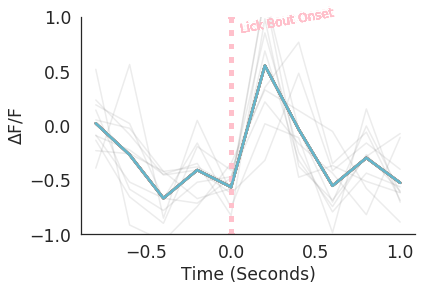

In [35]:
cell_idx = random.choice(np.where(pvals < 0.05)[0])
cell_idx = 162
print(cell_idx)
save_path = '/home/jamesrowland/Documents/Code/Vape/figures/lick_stas'
# add one so t=0 is at the final point of the pre period 
x_axis = np.arange(-pre_frames, post_frames) / fs + 1/fs
for trial in range(n_trials):
    
    plt.plot(x_axis,
             np.hstack((pre[cell_idx, :, trial], post[cell_idx, :, trial])),
             color='grey', alpha=0.15) 
    
    plt.axvline(x=0, linewidth=5, marker='d',linestyle=':', color='pink')
    plt.text(0.05,1,'Lick Bout Onset',rotation=10, color='pink')
    plt.plot(x_axis, np.hstack((mean_pre[cell_idx, :], mean_post[cell_idx, :])), linewidth=2.5)
    plt.ylim(-1,1)
    plt.xlabel('Time (Seconds)')
    plt.ylabel(r'$\Delta $F/F')
    plt.savefig(os.path.join(save_path, 'lickSTA_cell{}.png'.format(cell_idx)), bbox_inches="tight")

In [20]:
# correlations




